In [8]:
import os

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

print("in colab?", IN_COLAB)

if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/drive/")
    os.chdir('/content/drive/MyDrive/Denoise/cxr-experiment')
    !pwd # print current path
    # Install non-standard colab dependencies.
    !pip install torchinfo
    !pip install torchmetrics
    !pip install torchxrayvision
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image, ImageFile
import requests
from io import BytesIO
from IPython.display import display
import matplotlib.pyplot as plt
import torchvision.models as models
import time
from torchvision.io import read_image
from torch.utils.data import Dataset
import time
import datetime
import pickle
import os
import torchxrayvision as xrv
import oxr_utils as oxr

# after !pip install (in case of colab)
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio
import torchinfo

from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader

torch.cuda.empty_cache()

# Select device
device = "str"#torch.device("cpu")
if torch.cuda.is_available():
    device = "cuda"#torch.device("cuda")
    torch.cuda.empty_cache()

print("Device: {}".format(device))

# util functions
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


from oxr_utils import *

in colab? False
Device: cuda


In [9]:

if IN_COLAB:
    # USE THIS BLOCK COPIES THE NIH DATASET TO LOCAL COLAB INSTANCE AND IMPORTS THE NIH DATASET
    import zipfile
    import os
    from google.colab import drive
    drive.mount('/content/drive/')

    NIH_DATA_PATH = "/content/data/NIH_data"
    DRIVE_PATH = "/content/drive/MyDrive/Datasets"
    drive.mount('/content/drive/')

    zip_ref = zipfile.ZipFile(f"{DRIVE_PATH}/NIH_data.zip", 'r')
    if not os.path.exists(NIH_DATA_PATH):
      print("data path does not exist")
      zip_ref.extractall("/content/data") # can take 10-20min, but will make access very fast (30+ imgs/s)
      zip_ref.close()

else: 
   NIH_DATA_PATH = "../data/NIH_data" # local path to the NIH dataset # Desktop

print("NIH_DATA_PATH: ", NIH_DATA_PATH)

NIH_DATA_PATH:  ../data/NIH_data


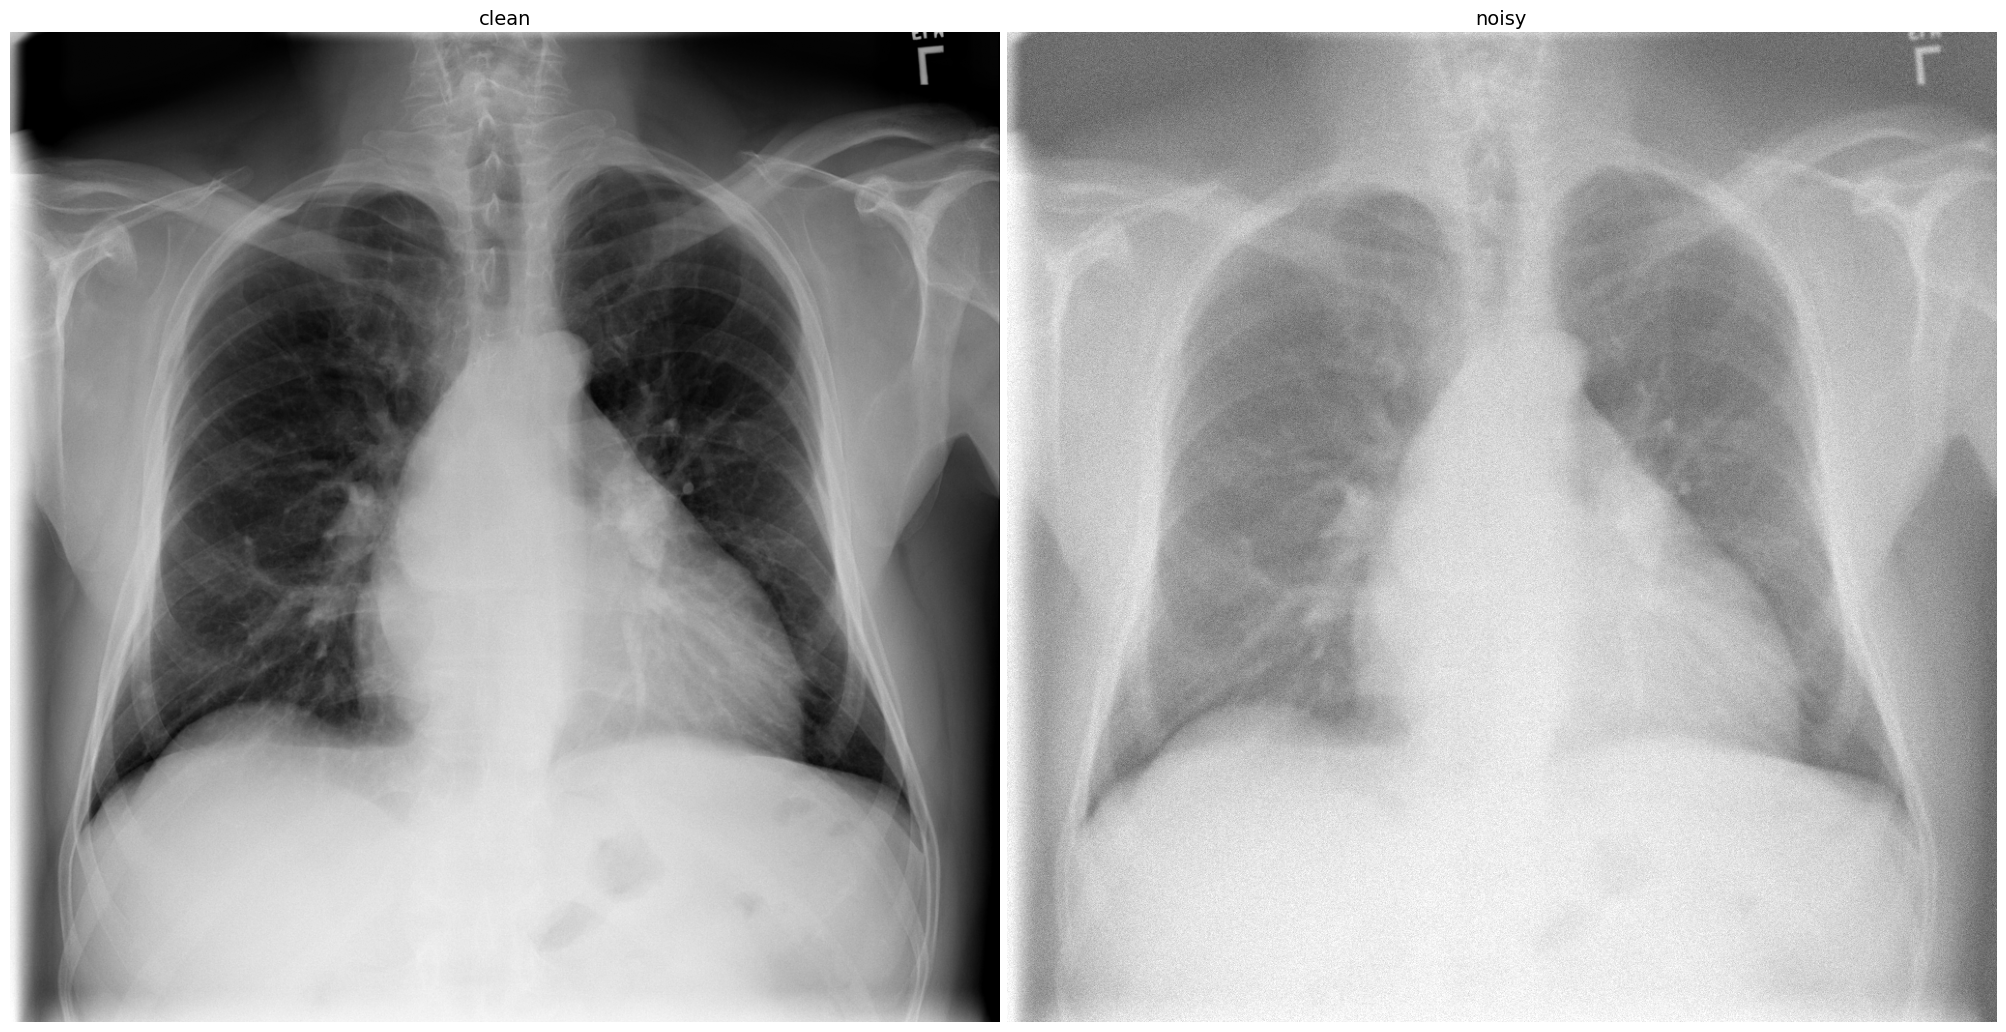

train/val/test: 32/80/80


In [10]:
# ------ Datset Loading ------

DATA_PATH = NIH_DATA_PATH 

nih_train = NIH_Dataset(DATA_PATH, split="train")
nih_val = NIH_Dataset(DATA_PATH, split="val")
nih_test = NIH_Dataset(DATA_PATH, split="test")

LIMIT_DATA = None # For Using Full Dataset
LIMIT_DATA = [32, 80, 80] # For Testing

if LIMIT_DATA:
  nih_train = torch.utils.data.Subset(nih_train, range(LIMIT_DATA[0])) if LIMIT_DATA[0] else nih_train
  nih_val = torch.utils.data.Subset(nih_val, range(LIMIT_DATA[1])) if LIMIT_DATA[1] else nih_val
  nih_test = torch.utils.data.Subset(nih_test, range(LIMIT_DATA[2])) if LIMIT_DATA[2] else nih_test

BATCH_SIZE = 4

train_dl = DataLoader(nih_train, batch_size=BATCH_SIZE, pin_memory=True, num_workers=4)
val_dl = DataLoader(nih_val, batch_size=BATCH_SIZE)
test_dl = DataLoader(nih_test, batch_size=BATCH_SIZE)

NOISE_STRENGTH = 0.4
MIN_SIGNAL = 0.05

NOISE_MOD = CameraApprox(1.0) #CameraDistort()

plot_cxr_images([nih_train[0][0][0], NOISE_MOD(nih_train[0][0])[0]], ["clean", "noisy"], figsize=(20, 40)) # show example
print(f"train/val/test: {len(nih_train)}/{len(nih_val)}/{len(nih_test)}")

In [11]:
# ------ Loss Functions ------
patch_loss = CombinedLoss([ oxr.MSELoss(), oxr.GradientLoss(loss_type="mse")], device=device).to(device)
diagnostic_loss = CombinedLoss([ oxr.MSELoss(), oxr.GradientLoss(loss_type="mse"), oxr.DiagnosisConsistencyLoss(True, device=device) ], device=device).to(device)

# ------ Training Configuration ------

TRAINING_STEPS = [
    dict(patch_size=256, epochs=3, batch_size=8, reset_lr=True, loss_fn=patch_loss),
    dict(patch_size=512, epochs=3,  batch_size=2, reset_lr=False, loss_fn=patch_loss),
    dict(patch_size=1024, epochs=4, batch_size=1, reset_lr=True, loss_fn=diagnostic_loss),
]

# Create one DataLoader per stage
training_step_dataloaders = [
    DataLoader(
        RandomPatchDataset(nih_train, patch_size=step["patch_size"]),
        batch_size=step["batch_size"],
        pin_memory=True,
        num_workers=4,
        prefetch_factor=2,
        drop_last=True
    )
    for step in TRAINING_STEPS
]

# Extract epochs and total epoch count
num_epochs = sum([step["epochs"] for step in TRAINING_STEPS])


In [12]:
# ------ Model Definition ------
import oxr_utils as oxr
model = oxr.REDNet(10).to(device)
torchinfo.summary(model, (1,1,1024,1024))

Layer (type:depth-idx)                   Output Shape              Param #
REDNet                                   [1, 1, 1024, 1024]        --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 64, 1024, 1024]       --
│    │    └─Conv2d: 3-1                  [1, 64, 1024, 1024]       640
│    │    └─ReLU: 3-2                    [1, 64, 1024, 1024]       --
│    └─Sequential: 2-2                   [1, 64, 1024, 1024]       --
│    │    └─Conv2d: 3-3                  [1, 64, 1024, 1024]       36,928
│    │    └─ReLU: 3-4                    [1, 64, 1024, 1024]       --
│    └─Sequential: 2-3                   [1, 64, 1024, 1024]       --
│    │    └─Conv2d: 3-5                  [1, 64, 1024, 1024]       36,928
│    │    └─ReLU: 3-6                    [1, 64, 1024, 1024]       --
│    └─Sequential: 2-4                   [1, 64, 1024, 1024]       --
│    │    └─Conv2d: 3-7                  [1, 64, 1024, 1024]       36,928
│ 

In [13]:
# ------ Loss Function and Metrics ------

log_metrics = {
    "loss": None, # will be set during training
    "MSE": nn.MSELoss().to(device),
    "SSIM": StructuralSimilarityIndexMeasure(data_range=1.0).to(device),
    "PSNR": PeakSignalNoiseRatio(data_range=1.0).to(device),
    "L1": nn.L1Loss().to(device),
    "Gradien MSE": GradientLoss(loss_type="mse").to(device),
    "Gradien L1": GradientLoss(loss_type="l1").to(device),
    "Diagnostic Loss": oxr.DiagnosisConsistencyLoss().to(device), # Note, this does not work for patch training!
}

In [14]:
# ------ Training ------
torch.cuda.empty_cache()


optimizer = optim.Adam(model.parameters(), lr=0.01)
ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

start_time = last_epoch_time = time.time()

# --- Logging ---
train_loss_hist = []
val_loss_hist = []
val_epoch_idxs = []


metrics_hist = []

# --- Training Loop with Patch Stages ---
global_epoch = 0
for step_idx, (step, train_dl) in enumerate(zip(TRAINING_STEPS, training_step_dataloaders)):
    print(f"\n--- Training Step {step_idx + 1}/{len(TRAINING_STEPS)}: "
          f"patch_size={step['patch_size']}, epochs={step['epochs']}, batch_size={step['batch_size']} ---")
    
    # Reset optimizer if specified
    if step["reset_lr"]:
        print("Resetting optimizer learning rate")
        optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    loss_function = step["loss_fn"].to(device)
    log_metrics["loss"] = loss_function

    for local_epoch in range(step["epochs"]):
        print(f"Train Epoch {global_epoch + 1}/{num_epochs}")
        model.train()
        train_loss = 0.0
        train_ssim = 0.0



        # --- Validation ---
        for i, (clean, _lbls) in enumerate(tqdm(train_dl)):
            optimizer.zero_grad()

            clean = clean.to(device)
            noisy = NOISE_MOD(clean).to(device)

            out = model(noisy)
            out = out.clamp(0.0,1.0)
            
            loss = loss_function(out, clean)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * noisy.size(0)

        train_loss /= len(train_dl.dataset)
        train_loss_hist.append(train_loss)
 

        plot_cxr_res(clean[0], noisy[0], out[0])
        # --- Validation ---
        print(f"Val. Epoch {global_epoch + 1}/{num_epochs}")
        model.eval()
        val_loss = 0.0

        val_metrics = {}
        for metric_name, metric in log_metrics.items():
            val_metrics[metric_name] = 0.0

        with torch.no_grad():
            for i, (clean, _lbls) in enumerate(tqdm(val_dl)):
               
                clean = clean.to(device)
                noisy = NOISE_MOD(clean).to(device)

                out = model(noisy)
                out = out.clamp(0.0,1.0)
            
                loss = loss_function(out, clean)
                val_loss += loss.item() * noisy.size(0)
                
                for metric_name, metric in log_metrics.items():
                    metric_value = metric(out, clean).item()
                    val_metrics[metric_name] += metric_value * noisy.size(0)
                
            for metric_name, metric_value in log_metrics.items():
                val_metrics[metric_name] /= len(val_dl.dataset)
                print(f"validation {metric_name}: {val_metrics[metric_name]:.6f}")
                
            metrics_hist.append(copy.deepcopy(val_metrics))
            
            val_loss /= len(val_dl.dataset)
            val_loss_hist.append(val_loss)
            val_epoch_idxs.append(global_epoch)

            plot_cxr_res(clean[0], noisy[0], out[0])

            torch.save({
                'epoch': global_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss
            }, f"models/checkpoints/checkpoint_epoch_{global_epoch}.pth")

        global_epoch += 1


--- Training Step 1/3: patch_size=256, epochs=3, batch_size=8 ---
Resetting optimizer learning rate
Train Epoch 1/10


  0%|          | 0/4 [00:14<?, ?it/s]


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [8, 64, 256, 256]], which is output 0 of ReluBackward0, is at version 2; expected version 1 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

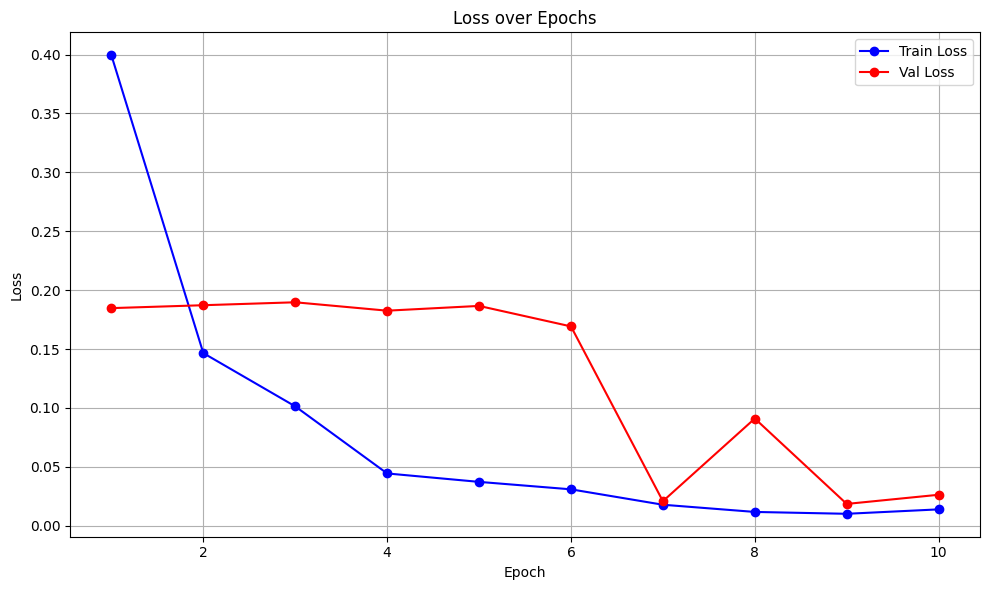

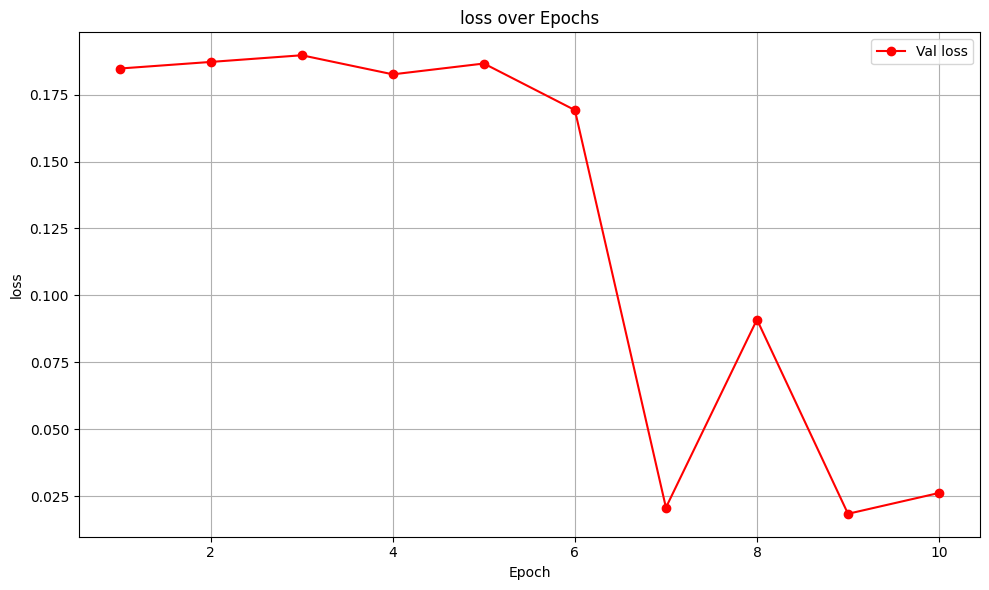

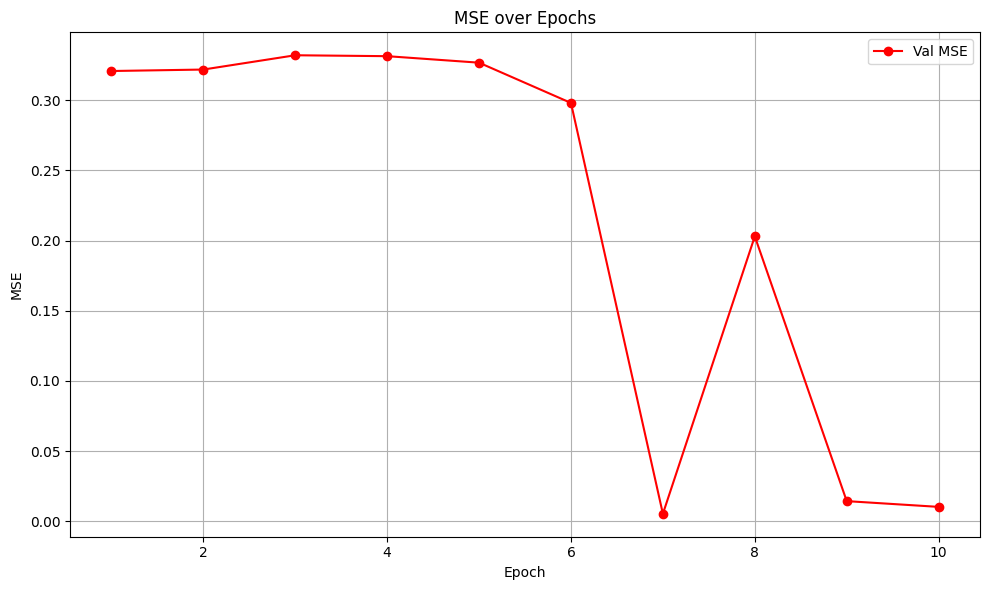

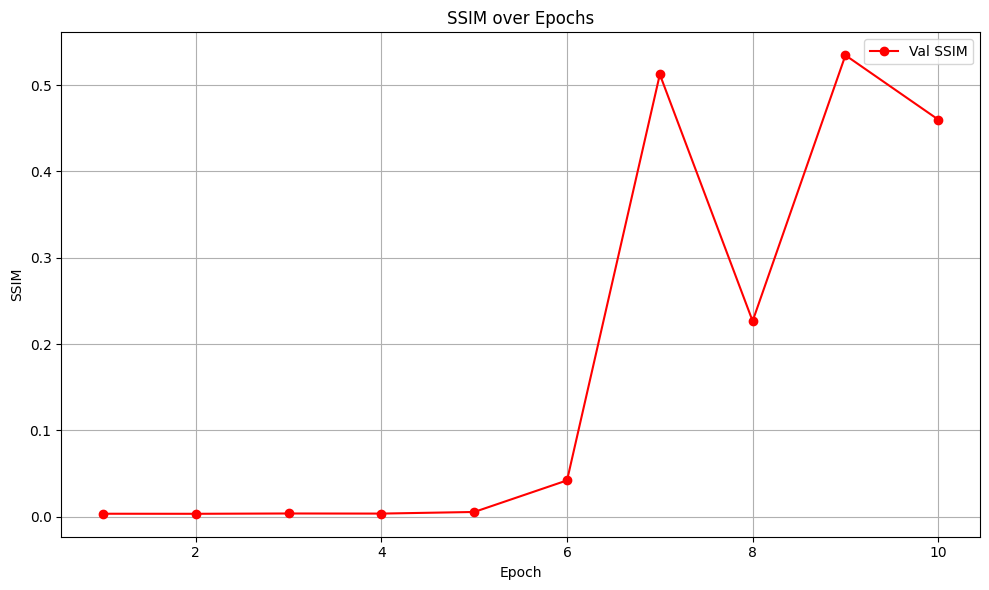

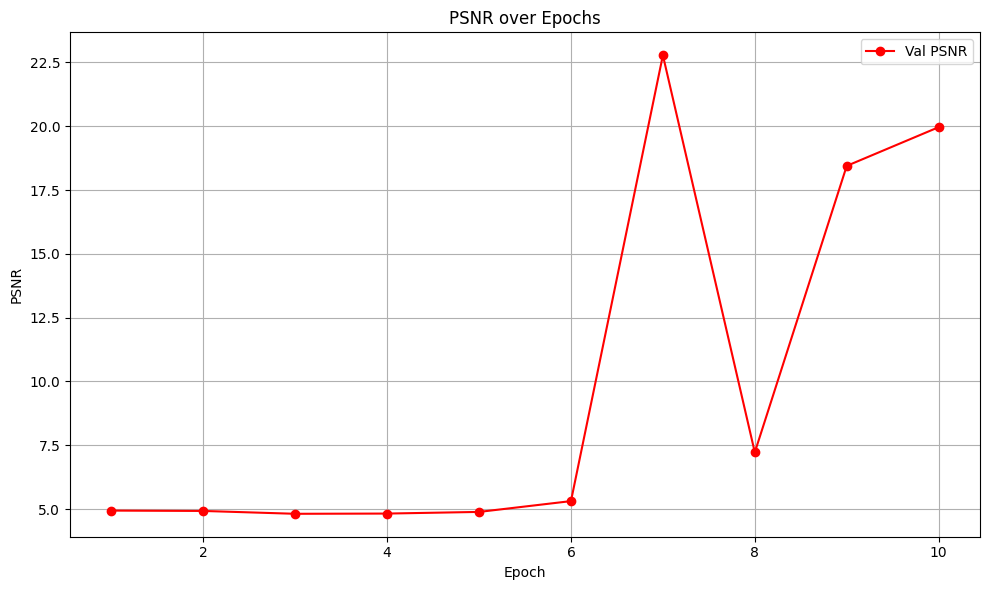

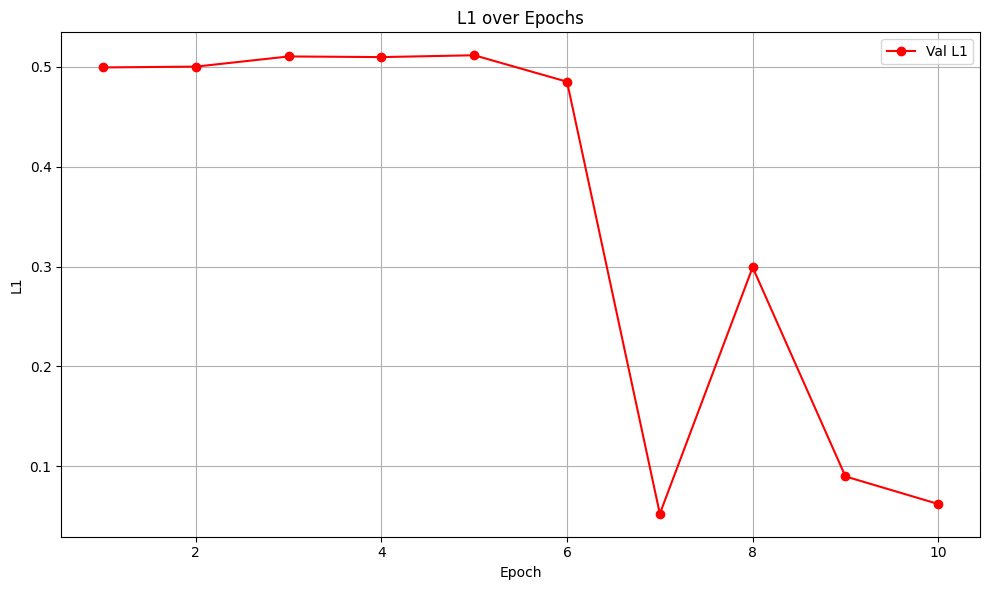

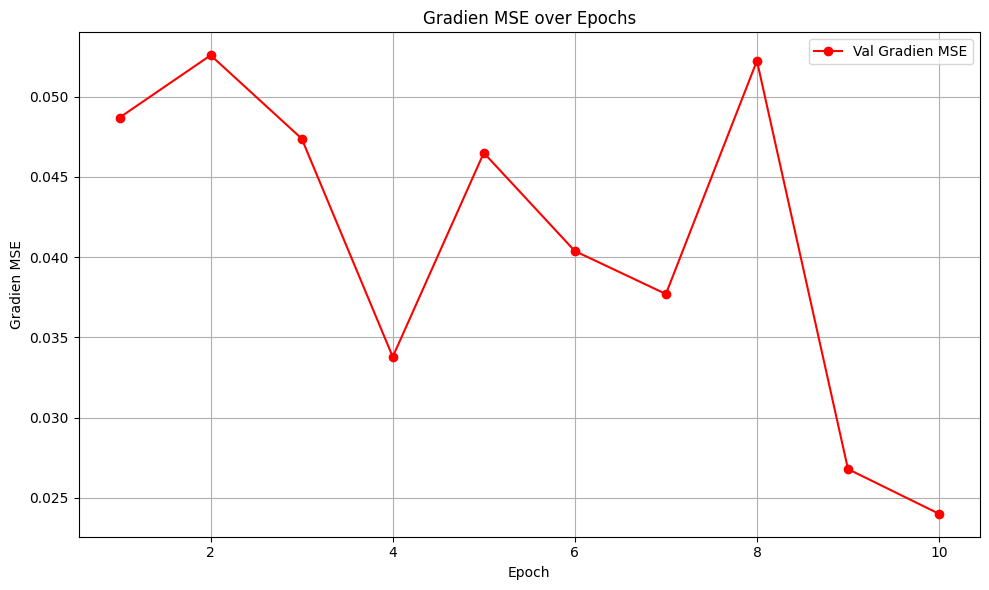

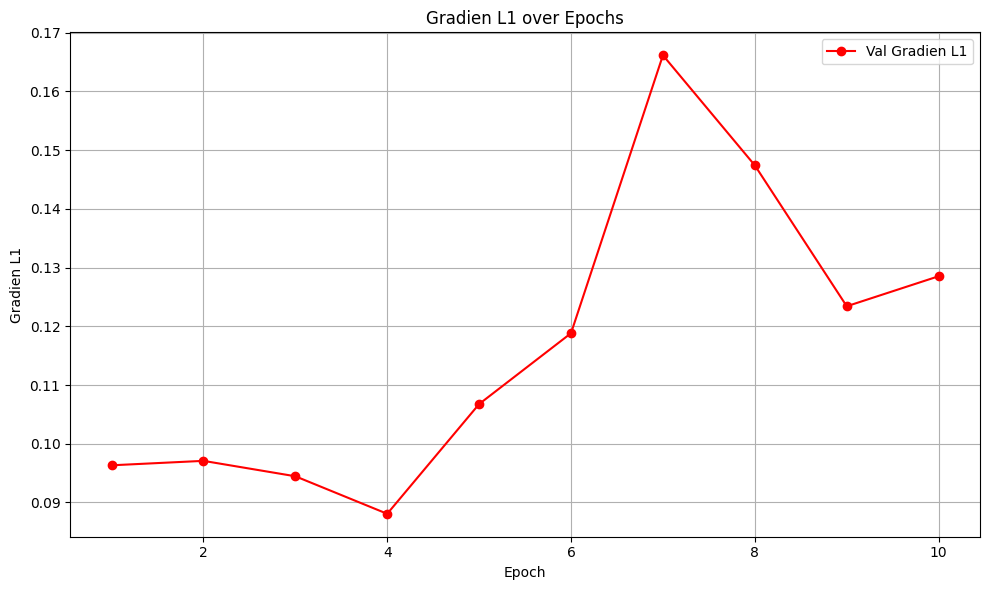

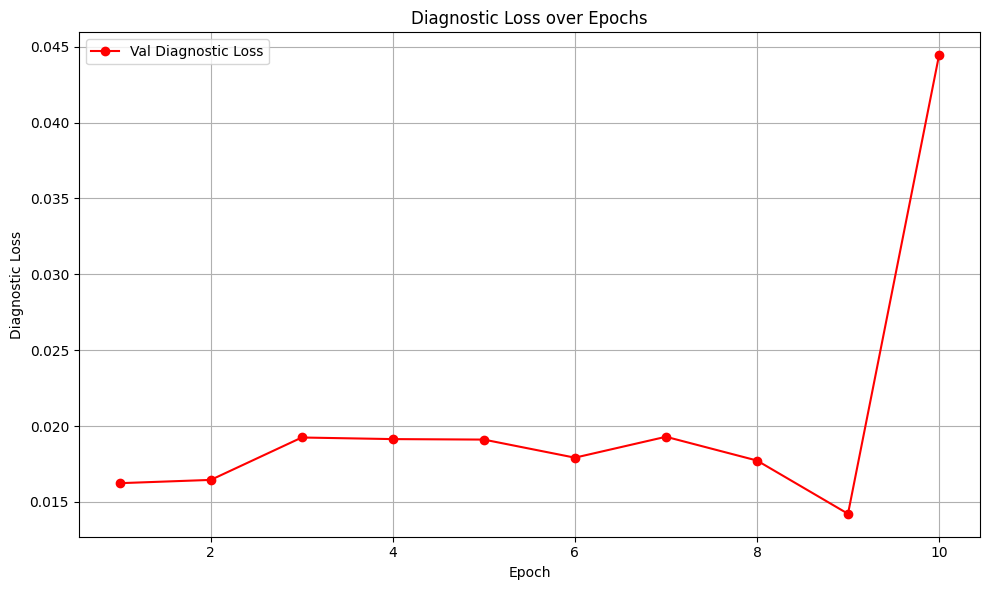

In [ ]:
# ------ Training Breakdown ------
epochs = list(range(1, num_epochs + 1))
val_epochs = [i + 1 for i in val_epoch_idxs]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_hist, "b-o", label="Train Loss")
plt.plot(val_epochs, val_loss_hist, "r-o", label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


for metric_name in log_metrics.keys():
    train_metric_hist = [metrics[metric_name] for metrics in metrics_hist]
    val_metric_hist = [metrics[metric_name] for metrics in metrics_hist]

    plt.figure(figsize=(10, 6))
    plt.plot(val_epochs, val_metric_hist, "r-o", label="Val " + metric_name)
    plt.title(f"{metric_name} over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# ------ Final Test Evaluation ------
model.eval()
test_loss = 0.0
test_ssim_score = 0.0

# --- Final Test Performance ---

random_three_letters = "".join(np.random.choice(list("abcdefghijklmnopqrstuvwxyz"), 3))
torch.save(model.state_dict(), f"models/{model.name()}_{random_three_letters}.pth")

import json
from datetime import datetime

model_metadata = {
    "model_name": model.name(),
    "model_name_random_suffix": random_three_letters,
    "model_file_name": f"{model.name()}_{random_three_letters}.pth",
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "architecture": "UNet",
    "s": model.s,
    "k": model.k,
    "num_parameters": sum(p.numel() for p in model.parameters()),
    "num_epochs": num_epochs,
    "num_train_images": len(train_dl.dataset),
    "val_loss": val_loss_hist[-1] if val_loss_hist else None,
    "test_loss": test_loss,
}

with torch.no_grad():
    val_metrics = {}
    for metric_name in log_metrics.keys():
        val_metrics[metric_name] = 0.0

    for i, (clean, _lbls) in enumerate(tqdm(test_dl)):
        clean = clean.to(device)
        noisy = NOISE_MOD(clean).to(device)
        res = model(noisy)
        out = (noisy + res).clamp(0.0,1.0)
    
        loss = loss_function(out, clean)
        val_loss += loss.item() * noisy.size(0)
        
        for metric_name, metric in log_metrics.items():
            metric_value = metric(out, clean).item()
            val_metrics[metric_name] += metric_value * noisy.size(0)
        
    for metric_name in log_metrics.keys():
        val_metrics[metric_name] /= len(test_dl.dataset)
        print(f"testing {metric_name}: {val_metrics[metric_name]:.6f}")
        model_metadata[f"metric_testing_{metric_name}"] = val_metrics[metric_name]


with open(f"models/{model.name()}_{random_three_letters}_meta.json", "w") as f:
    json.dump(model_metadata, f, indent=4)

torch.save({
    "model_state": model.state_dict(),
    "metadata": model_metadata
}, f"models/{model.name()}_{random_three_letters}_bundle.pth")

print(f"!saved model: '{model.name()}_{random_three_letters}'!")

100%|██████████| 20/20 [00:26<00:00,  1.32s/it]

testing loss: 0.026721
testing MSE: 0.010430
testing SSIM: 0.446141
testing PSNR: 19.966382
testing L1: 0.061527
testing Gradien MSE: 0.026494
testing Gradien L1: 0.133383
testing Diagnostic Loss: 0.043240
!saved model: 'res-unet-s4k32_xwc'!
